SVS file detected. Extracting metadata


<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids
2025-07-11 15:17:47.838 | WARNING  | palom.reader:auto_format_pyramid:55 - Unable to detect pyramid levels, it may take a while to compute thumbnails during coarse alignment


Tile width: 240 Tile height: 240
Tile shape is not equal to standard 1024x1024. New image will save with 1024x1024 tile shape
Current number of levels: 4
OME.TIF file detected. Extracting metadata
Tile width: 1024 Tile height: 1024 Current number of levels: 9


2025-07-11 15:18:25.313 | DEBUG    | palom.register:cv2_feature_detect_and_match:288 - keypts L:5000, keypts R:5000
2025-07-11 15:18:28.079 | DEBUG    | palom.register:cv2_feature_detect_and_match:288 - keypts L:5000, keypts R:5000
2025-07-11 15:18:31.215 | DEBUG    | palom.register:cv2_feature_detect_and_match:288 - keypts L:5000, keypts R:5000
2025-07-11 15:18:33.648 | DEBUG    | palom.register:cv2_feature_detect_and_match:288 - keypts L:5000, keypts R:5000
2025-07-11 15:18:37.151 | INFO     | palom.align:compute_shifts:203 - Computing block-wise shifts
Computing shifts: 100%|##########| 37244/37244 [00:33<00:00, 1102.32it/s]
2025-07-11 15:20:01.517 | INFO     | palom.reader:pixel_size:156 - Detected pixel size: 0.2125 µm


Writing pyramid level 0
Writing pyramid level 1 with shape (49298, 25609, 3)
Writing pyramid level 2 with shape (24649, 12804, 3)
Writing pyramid level 3 with shape (12324, 6402, 3)
Writing pyramid level 4 with shape (6162, 3201, 3)
✓  Registered slide written to: /rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/TMP-IL-Pilot/20250515__183240__CIMAC_Validation/Xenium_H&E_PCF_TMA_5-28-2025_registered_test2.ome.tif


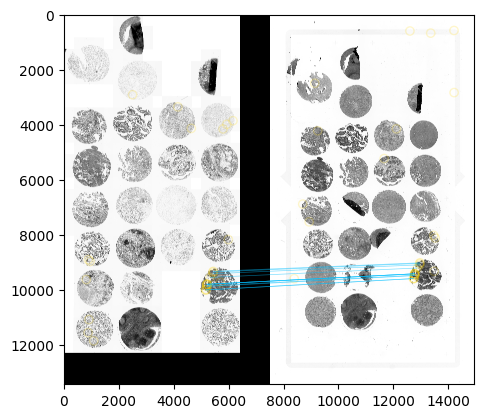

In [2]:
#%%

import os 
import palom
import numpy as np
import pyvips
import tifffile as tf
import cv2
import openslide 
from scipy.ndimage import median_filter

# %% Define slide 
root_dir = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/TMP-IL-Pilot/20250515__183240__CIMAC_Validation"
data_dict = {
        "output-XETG00522__0066398__Region_1__20250515__183305":"Xenium H&E Meso1-ICON2 TMA 5-21-2025.svs" ,
        "output-XETG00522__0066402__Region_1__20250515__183305":"Xenium H&E PCF TMA 5-28-2025.svs"
        }
file_num = 1
xenium_folder = list(data_dict.keys())[file_num]
slide_file = os.path.join(root_dir, data_dict[xenium_folder])
morph_file = os.path.join(root_dir, xenium_folder, "morphology_focus", "morphology_focus_0000.ome.tif")

#%%
rotation_angle = 270  
output_prefix = slide_file.replace(".svs", f"_matching_orientation")
rotated_ome_file = output_prefix + ".ome.tif"

#%%

def img_resize(img, scale_factor):
    width = int(np.floor(img.shape[1] * scale_factor))
    height = int(np.floor(img.shape[0] * scale_factor))
    return cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)

def write_ome_tif(filename, image, photometric_interp, metadata, subresolutions=8,
                  tile_size=(1024, 1024), sub_res=True, level_ds=None):
    """
    Save image as OME-TIFF with pyramid levels defined by downsample factors.

    Parameters
    ----------
    filename : str
        Path to output OME-TIFF file.
    image : np.ndarray
        Base level image (level 0).
    photometric_interp : str
        'rgb' or 'minisblack' depending on image type.
    metadata : dict
        OME metadata dictionary, should include PhysicalSizeX and PhysicalSizeY.
    subresolutions : int
        Number of pyramid levels (excluding base level).
    tile_size : tuple
        Tile size for writing TIFF.
    sub_res : bool
        Whether to generate subresolution levels.
    level_ds : list of tuple
        List of (downsample_x, downsample_y) tuples, one per level including level 0.
    """
    with tf.TiffWriter(filename, bigtiff=True) as tif:
        px_size_x = metadata['PhysicalSizeX']
        px_size_y = metadata['PhysicalSizeY']

        options = dict(
            photometric=photometric_interp,
            tile=tile_size,
            maxworkers=16,
            compression="jpeg",
            compressionargs={"level": 85},  # Can be tuned between 75–95
            resolutionunit='CENTIMETER',
        )

        # Write base level (level 0)
        print("Writing pyramid level 0")
        tif.write(
            image,
            subifds=subresolutions,
            resolution=(1e4 / px_size_x, 1e4 / px_size_y),
            metadata=metadata,
            **options
        )

        # Write subresolution pyramid levels
        if sub_res and level_ds:
            print("Using level_ds to define pyramid sizes")
            for i, (ds_x, ds_y) in enumerate(level_ds[1:], start=1):  # Skip level 0
                new_w = int(round(image.shape[1] / ds_x))
                new_h = int(round(image.shape[0] / ds_y))

                if photometric_interp == 'minisblack':
                    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
                    if resized.ndim == 2:
                        resized = resized[np.newaxis, ...]
                else:
                    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

                print(f"Writing pyramid level {i} with shape {resized.shape}")
                tif.write(
                    resized,
                    subfiletype=1,
                    resolution=(1e4 / (ds_x * px_size_x), 1e4 / (ds_y * px_size_y)),
                    **options
                )

        elif sub_res:
            print("Warning: level_ds not provided. Falling back to halving strategy.")
            current = image.copy()
            scale = 1
            for i in range(subresolutions):
                scale *= 2
                new_w = current.shape[1] // 2
                new_h = current.shape[0] // 2
                current = cv2.resize(current, (new_w, new_h), interpolation=cv2.INTER_AREA)

                print(f"Writing pyramid level {i + 1} with shape {current.shape}")
                tif.write(
                    current,
                    subfiletype=1,
                    resolution=(1e4 / (scale * px_size_x), 1e4 / (scale * px_size_y)),
                    **options
                )


def extract_metadata(file_path):
    if "ome.tif" in file_path:
        # -------------------------------
        # Prepare metadata for output file
        # -------------------------------
        # Extract tiling information and pyramid level count from original H&E image
        with tf.TiffFile(file_path) as original_tif:
            print("OME.TIF file detected. Extracting metadata")
            tile_width = original_tif.pages[0].tilewidth
            tile_height = original_tif.pages[0].tilelength
            num_subifds = len(original_tif.pages[0].subifds)
            print("Tile width:", tile_width, "Tile height:", tile_height, "Current number of levels:", num_subifds+1)

            meta = tf.xml2dict(original_tif.ome_metadata)

            image_block = meta['OME']['Image']
            if isinstance(image_block, list):
                image_block = image_block[0]

            pixels_block = image_block['Pixels']
            res = (
                float(pixels_block.get('PhysicalSizeX', 0)),
                float(pixels_block.get('PhysicalSizeY', 0))
)
            px_size_x, px_size_y = res
            unit = meta['OME']['Image']['Pixels']['PhysicalSizeXUnit']
            channel_names = []
            try:
                channels = meta['OME']['Image']['Pixels']['Channel']
                
                if isinstance(channels, list):  # multiple channels
                    for ch in channels:
                        channel_names.append(ch['Name'])
                elif isinstance(channels, dict):  # single channel
                    channel_names.append(channels['Name'])
            except KeyError:
                channel_names = None

    elif "svs" in file_path:
        print("SVS file detected. Extracting metadata")
        slide = openslide.open_slide(file_path)
        px_size_x = float(slide.properties.get('openslide.mpp-x'))
        px_size_y = float(slide.properties.get('openslide.mpp-y'))
        tile_width, tile_height = slide.properties.get("openslide.level[0].tile-width"), slide.properties.get("openslide.level[0].tile-height")
        print("Tile width:", tile_width, "Tile height:", tile_height)
        if tile_width != 1024 or tile_height != 1024:
            print("Tile shape is not equal to standard 1024x1024. New image will save with 1024x1024 tile shape")
            tile_width, tile_height = 1024, 1024  # standard for ome.tiff

        # Get number of pyramid levels
        num_levels = slide.level_count
        # Get dimensions at each level
        print("Current number of levels:", num_levels)
        num_subifds = num_levels - 1
        unit = "µm"  # standard unit as well
        channel_names = None


    # --- Prepare metadata dictionary ---
    metadata = {
        'axes': 'YXC',
        'PhysicalSizeX': px_size_x,
        'PhysicalSizeY': px_size_y,
        'PhysicalSizeXUnit': unit,
        'PhysicalSizeYUnit': unit,
        'Channel': {'Name': channel_names}
    }
    return metadata, tile_width


def get_target_level_downsamples(morph_image_path):
    """
    Extracts level dimensions and level downsamples from a morphology OME-TIFF image.

    Parameters
    ----------
    morph_image_path : str
        Path to the morphology image (.ome.tif)

    Returns
    -------
    level_dimensions : list of tuple
        Width and height of each pyramid level.

    level_downsamples : list of tuple
        Downsample factors (x, y) for each pyramid level relative to level 0.
    """
    with tf.TiffFile(morph_image_path) as tif:
        main_page = tif.pages[0]
        level_dimensions = [(main_page.imagewidth, main_page.imagelength)]

        if main_page.subifds:
            for subifd in main_page.pages:
                level_dimensions.append((subifd.imagewidth, subifd.imagelength))

        base_w, base_h = level_dimensions[0]
        level_downsamples = [(base_w / w, base_h / h) for (w, h) in level_dimensions]

    return level_dimensions, level_downsamples


def rotate_image(slide_file, rotation_angle):
    """
    Rotates a WSI using pyvips and returns a NumPy RGB array.
    
    Parameters:
    -----------
    slide_file : str
        Path to the input image (.svs, .tif, etc.)
    rotation_angle : int
        One of [90, 180, 270] degrees (clockwise)

    Returns:
    --------
    rotated_np : np.ndarray
        Rotated image as a NumPy array (H, W, 3), dtype=uint8
    """
    vips_img = pyvips.Image.new_from_file(slide_file, access="sequential")
    print("Preprocessing image. Rotation: ", rotation_angle)
    # Apply rotation if needed
    if rotation_angle == 0:
        print("No rotation applied — standardizing image format only.")
        rotated = vips_img
    elif rotation_angle == 90:
        rotated = vips_img.rot90()
    elif rotation_angle == 180:
        rotated = vips_img.rot180()
    elif rotation_angle == 270:
        rotated = vips_img.rot270()
    else:
        raise ValueError("Only 0, 90, 180, and 270 degrees are supported.")

    # --- Convert to NumPy array ---
    raw_bytes = rotated.write_to_memory()
    rotated_np = np.frombuffer(raw_bytes, dtype=np.uint8)
    rotated_np = rotated_np.reshape((rotated.height, rotated.width, rotated.bands))

    # Ensure 3 channels only
    if rotated_np.ndim == 3 and rotated_np.shape[2] == 4:
        print("Stripping alpha channel from image")
        rotated_np = rotated_np[:, :, :3]

    # Ensure dtype is uint8
    if rotated_np.dtype != np.uint8:
        print("Converting image to uint8")
        rotated_np = rotated_np.astype(np.uint8)
    return rotated_np

#%%
metadata, tile_size = extract_metadata(slide_file) 
morph_metadata, tile_size = extract_metadata(morph_file) 

_, level_ds = get_target_level_downsamples(morph_file)


#%%

if not os.path.exists(rotated_ome_file):
    rotated_np = rotate_image(slide_file, rotation_angle)

    # --- Write rotated image as OME-TIFF ---
    write_ome_tif(
        rotated_ome_file,
        rotated_np,
        photometric_interp='rgb',
        metadata=metadata,
        # subresolutions=num_su bifds,
        tile_size=(tile_size, tile_size),
        sub_res=True,
        level_ds=level_ds,
    )

    print("Saved rotated OME-TIFF:", rotated_ome_file)

moving_file = rotated_ome_file
registered_ome_path = moving_file.replace("matching_orientation", "registered")

# %%

# --------------------------------------------------
# 0. paths & readers
# --------------------------------------------------
output_path = registered_ome_path.replace(" ", "_").replace(".ome.tif", "_test2.ome.tif")

ref_reader   = palom.reader.OmePyramidReader(morph_file)
moving_reader = palom.reader.OmePyramidReader(moving_file)
_ = ref_reader.pyramid[0].blocks.ravel()[0].persist()
_ = moving_reader.pyramid[0].blocks.ravel()[0].persist()

# --------------------------------------------------
# 1. choose levels / channels
# --------------------------------------------------
LEVEL           = 0          # full-res
THUMBNAIL_LEVEL = 3
CHANNEL_REF     = 0          # DAPI
CHANNEL_MOVING  = 1          # H&E green

# --------------------------------------------------
# 2. build aligner
# --------------------------------------------------
aligner = palom.align.Aligner(
    ref_img  = ref_reader.read_level_channels(LEVEL, CHANNEL_REF),
    moving_img = moving_reader.read_level_channels(LEVEL, CHANNEL_MOVING),
    ref_thumbnail    = ref_reader.read_level_channels(THUMBNAIL_LEVEL, CHANNEL_REF).compute(),
    moving_thumbnail = moving_reader.read_level_channels(THUMBNAIL_LEVEL, CHANNEL_MOVING).compute(),
    ref_thumbnail_down_factor    = ref_reader.level_downsamples[THUMBNAIL_LEVEL] / ref_reader.level_downsamples[LEVEL],
    moving_thumbnail_down_factor = moving_reader.level_downsamples[THUMBNAIL_LEVEL] / moving_reader.level_downsamples[LEVEL],
)

# --------------------------------------------------
# 3. global affine + block shifts (with mask)
# --------------------------------------------------
aligner.coarse_register_affine(n_keypoints=5000)
aligner.compute_shifts(mask = aligner.ref_img > 0)   # ignore background
aligner.original_shifts = aligner.shifts.copy()       # save raw

# --------------------------------------------------
# 4. median-smooth & drop outliers
# --------------------------------------------------
# smooth the 2-D grid of shifts (3×3 kernel)
shift_med = median_filter(
    aligner.shifts.reshape(*aligner.grid_shape, 2),
    size = (3, 3, 1)
).reshape(-1, 2)

ABS_LIMIT = 120.0                                    # pixels
too_far   = np.linalg.norm(shift_med, axis=1) > ABS_LIMIT

# commit the cleaned shifts
aligner.shifts  = shift_med
aligner.shifts[too_far] = [0, 0]                     # fall back to coarse affine

# --------------------------------------------------
# 5. build block-wise affine matrices
# --------------------------------------------------
mxs_da = aligner.block_affine_matrices_da            # uses cleaned shifts

# --------------------------------------------------
# 6. warp full-res H&E
# --------------------------------------------------
transformed_HE = palom.align.block_affine_transformed_moving_img(
        ref_img    = aligner.ref_img,
        moving_img = moving_reader.pyramid[LEVEL],
        mxs        = mxs_da
)

# --------------------------------------------------
# 7. write channels-last OME-TIFF
# --------------------------------------------------
rgb = np.moveaxis(transformed_HE.compute(), 0, -1).astype(np.uint8)   # (H,W,3)

meta = {
    'axes'             : 'YXC',
    'PhysicalSizeX'    : ref_reader.pixel_size,
    'PhysicalSizeY'    : ref_reader.pixel_size,
    'PhysicalSizeXUnit': 'µm',
    'PhysicalSizeYUnit': 'µm',
    'Channel'          : {'Name': None}
}

write_ome_tif(
    filename           = output_path,
    image              = rgb,
    photometric_interp = 'rgb',
    metadata           = meta,
    subresolutions     = 4,
    tile_size          = (1024, 1024),
    sub_res            = True,
)

print("✓  Registered slide written to:", output_path)

# # %%
# import tifffile
# import matplotlib.pyplot as plt
# import numpy as np

# tif_path = output_path

# with tifffile.TiffFile(tif_path) as tif:
#     base = tif.pages[0]
#     subifds = base.pages  # pyramid levels

#     print(f"Base level shape: {base.shape}")
#     print(f"Number of pyramid levels: {len(subifds)}")

#     for i, page in enumerate(subifds):
#         print(f"Level {i+1} shape: {page.shape}, dtype: {page.dtype}")

#     # Choose the level to visualize
#     level = 1  # change this to see other levels

#     img = subifds[level].asarray()

# # Convert (C, H, W) to (H, W, C) if needed
# if img.ndim == 3 and img.shape[0] == 3:
#     img = np.moveaxis(img, 0, -1)

# print("Min pixel value:", img.min())
# print("Max pixel value:", img.max())

# # Plot
# plt.figure(figsize=(10, 10))
# plt.imshow(img)
# plt.axis("off")
# plt.title(f"Pyramid Level {level + 1}")
# plt.show()

# %%


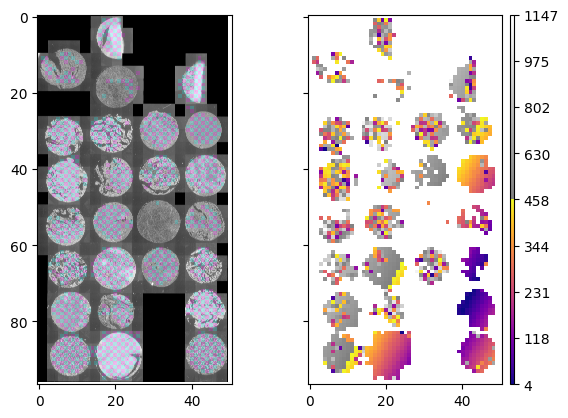

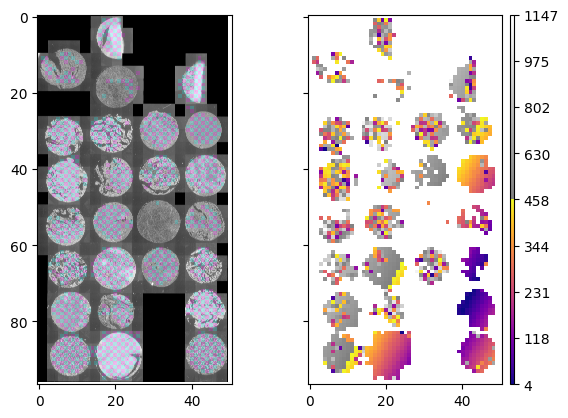

In [3]:
# after you've run aligner.compute_shifts()
fig = aligner.plot_shifts()              # before constrain (raw shifts)

# after aligner.constrain_shifts()
aligner.constrain_shifts()
fig2 = aligner.plot_shifts()             # constrained shifts
